In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib as mpl

import readdy_learn.analyze.analyze as ana
import readdy_learn.analyze.basis as basis

import pynumtools.kmc as kmc

mpl.rcParams['figure.figsize'] = (13, 13)
import matplotlib.pyplot as plt

## regulation of two protein types A and B

In [8]:
# species DA, DB, MA, MB, A, B
n_species = 6
desired_rates = np.array([
    2., # DA -> DA + MA, transcription A
    2., # DB -> DB + MB, transcription B
    2., # MA -> MA + A, translation A
    2., # MB -> MB + B, translation B
    0.1,# MB + A -> A, A regulates B
    0.1,# MA + B -> B, B regulates A
    1., # MA -> 0, decay
    1., # A -> 0, decay
    1., # MB -> 0, decay
    1., # B -> 0, decay
    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]) # rest is nonsense

initial_states = [
    [1, 1, 0, 0, 0, 0], [1, 1, 3, 0, 0, 0], [1, 1, 1, 0, 4, 0], [1, 1, 0, 3, 0, 1],
]
initial_states = [np.array([arr]) for arr in initial_states]

noise_variance = 0.1

In [19]:
ld_derivative_config = {
                'ld_derivative_atol': 1e-4,
                'ld_derivative_rtol': None,
                'ld_derivative_linalg_solver_maxit': 100000,
                'ld_derivative_alpha': 1e-1,
                'ld_derivative_solver': 'spsolve',
                'ld_derivative_linalg_solver_tol': 1e-10,
                'ld_derivative_use_preconditioner': False
            }
def set_up_system(init_state):
    sys = kmc.ReactionDiffusionSystem(diffusivity=n_species*[[[0.]]], n_species=n_species, n_boxes=1,
                                      init_state=init_state, species_names=["DA", "MA", "A"])
    sys.add_fission("DA", "DA", "MA", np.array([desired_rates[0]])) # DA -> DA + MA transcription
    sys.add_fission("DB", "DB", "MB", np.array([desired_rates[1]])) # DB -> DB + MB transcription
    sys.add_fission("MA", "MA", "A", np.array([desired_rates[2]])) # MA -> MA + A translation
    sys.add_fission("MB", "MB", "B", np.array([desired_rates[3]])) # MB -> MB + B translation
    sys.add_fusion("MB", "A", "A", np.array([desired_rates[4]]))  # MB + A -> A, A regulates B
    sys.add_fusion("MA", "B", "B", np.array([desired_rates[5]]))  # MA + B -> B, B regulates A
    sys.add_decay("MA", np.array([desired_rates[6]])) # MA -> 0 mRNA A decay
    sys.add_decay("A", np.array([desired_rates[7]])) # A -> 0 protein decay
    sys.add_decay("MB", np.array([desired_rates[8]])) # MB -> 0 mRNA B decay
    sys.add_decay("B", np.array([desired_rates[9]])) # B -> 0 protein decay
    
    return sys

def get_bfc():
    bfc = basis.BasisFunctionConfiguration(n_species)
    bfc.add_fission(0, 0, 2) # DA -> DA + MA, transcription A
    bfc.add_fission(1, 1, 3) # DB -> DB + MB, transcription B
    bfc.add_fission(2, 2, 4) # MA -> MA + A, translation A
    bfc.add_fission(3, 3, 5) # MB -> MB + B, translation B
    bfc.add_fusion(3, 4, 4)  # MB + A -> A, A regulates B
    bfc.add_fusion(2, 5, 5)  # MA + B -> B, B regulates A
    bfc.add_decay(2) # MA -> 0, decay
    bfc.add_decay(4) # A -> 0, decay
    bfc.add_decay(3) # MB -> 0, decay
    bfc.add_decay(5) # B -> 0, decay
    
    # some more stuff with A
    bfc.add_fusion(0, 2, 0)  # DA + MA -> DA, nope
    bfc.add_conversion(0, 2) # DA -> MA, nope
    bfc.add_conversion(2, 0) # MA -> DA, nope
    bfc.add_conversion(0, 4) # DA -> A, nope
    bfc.add_conversion(4, 0) # A -> DA, nope
    bfc.add_conversion(2, 4) # MA -> A, nope
    bfc.add_conversion(4, 2) # A -> MA, nope
    bfc.add_fusion(0, 4, 2) # DA + A -> MA, nope
    bfc.add_fission(2, 0, 4) # MA -> DA + A, nope
    bfc.add_fusion(0, 2, 4) # DA + MA -> A, nope
    bfc.add_fission(4, 0, 2) # A -> DA + MA, nope
    
    # some more stuff with B
    bfc.add_fusion(1, 3, 1)  # DB + MB -> DB, nope
    bfc.add_conversion(1, 3) # DB -> MB, nope
    bfc.add_conversion(3, 1) # MB -> DB, nope
    bfc.add_conversion(1, 5) # DB -> B, nope
    bfc.add_conversion(5, 1) # B -> DB, nope
    bfc.add_conversion(3, 5) # MB -> B, nope
    bfc.add_conversion(5, 3) # B -> MB, nope
    bfc.add_fusion(1, 5, 3) # DB + B -> MB, nope
    bfc.add_fission(3, 1, 5) # MB -> DB + B, nope
    bfc.add_fusion(1, 3, 5) # DB + MB -> B, nope
    bfc.add_fission(5, 1, 3) # B -> DB + MB, nope
    
    # some more cross nonsense
    bfc.add_fusion(2, 4, 4)  # MA + A -> A, A regulates A, nope
    bfc.add_fusion(3, 5, 5)  # MB + B -> B, B regulates B, nope
    
    assert bfc.n_basis_functions == len(desired_rates), \
        "got {} basis functions but only {} desired rates".format(bfc.n_basis_functions, len(desired_rates))
    return bfc

def plot_cv_results(cv, mainscore=0, best_params_ix_l1=1.):
    xs = {}
    ys = {}
    allys = {}
    for r in cv.result:
        l1_ratio = r['l1_ratio']
        if len(r['scores']) > 0:
            if l1_ratio in xs.keys():
                xs[l1_ratio].append(r['alpha'])
                ys[l1_ratio].append(r['scores'][mainscore])
                allys[l1_ratio].append(r['scores'])
            else:
                xs[l1_ratio] = [r['alpha']]
                ys[l1_ratio] = [r['scores'][mainscore]]
                allys[l1_ratio] = [r['scores']]
    f, ax = plt.subplots(figsize=(20, 20))
    for l1_ratio in xs.keys():
        l1xs = np.array(xs[l1_ratio])
        l1ys = np.array(ys[l1_ratio])
        l1allys = np.array([np.array(arr) for arr in allys[l1_ratio]]).T
        sorts = np.argsort(l1xs)
        l1xs = l1xs[sorts]
        l1ys = l1ys[sorts]
        
        l1allys = [arr[sorts] for arr in l1allys]
        if l1_ratio == best_params_ix_l1 or best_params_ix_l1 is None:
            ax.plot(l1xs, -l1ys, label='score l1={}'.format(l1_ratio))
            
            for ix, _ys in enumerate(l1allys):
                if np.argmin(-_ys) != 0:
                    # print("found one: {} with argmin {}".format(ix, np.argmin(_ys)))
                    pass
                # ax.plot(l1xs, -_ys, label='test set {}'.format(ix))
                pass
    f.suptitle('Cross-validation scores')
    ax.set_ylabel('score')
    ax.set_xlabel('$\\alpha$')
    plt.legend()
    plt.show()
def plot_rates_bar(desired_rates, estimated_rates):
    assert len(desired_rates) == len(estimated_rates)
    N = len(desired_rates)
    ind = np.arange(N)
    width = .35
    fig, ax = plt.subplots()
    bar1 = ax.bar(ind, desired_rates, width, color='blue')
    bar2 = ax.bar(ind+width, estimated_rates, width, color='green')
    ax.set_xticks(ind + width / 2)
    ax.legend((bar1[0], bar2[0]), ('Desired', 'Estimated'))
    ax.set_xticklabels(["{}".format(i) for i in ind])
    plt.show()
def best_params(cv, scoreidx=None):
    current_best_score = -1
    alpha = -1
    l1_ratio = -1
    
    for r in cv.result:
        if len(r['scores']) > 0:
            if scoreidx is None:
                currscore = np.mean(r['scores'])
            else:
                currscore = r['scores'][scoreidx]
            if current_best_score >= 0:
                if -currscore < current_best_score:
                    current_best_score = -currscore
                    alpha = r['alpha']
                    l1_ratio = r['l1_ratio']
            else:
                current_best_score = -currscore
                alpha = r['alpha']
                l1_ratio = r['l1_ratio']
    return alpha, l1_ratio, current_best_score
def do_the_cv(analysis, n, alphas, l1_ratios, tol=1e-12, solvetol=1e-15, plot_cv_for=None, best_params_ix=None,
              best_params_ix_l1=None):
    cv_n = analysis.elastic_net(n, alphas, l1_ratios, tol=tol)
    if plot_cv_for is not None:
        plot_cv_results(cv_n, mainscore=plot_cv_for, best_params_ix_l1=best_params_ix_l1)
    alpha, l1_ratio, score = best_params(cv_n, best_params_ix)
    print("params: alpha={}, l1={} with corresponding score {}".format(alpha, l1_ratio, score))
    cutoff = 1e-8
    rates = analysis.solve(n, alpha, l1_ratio, tol=solvetol, recompute=True)
    rates[np.where(rates <= cutoff)] = 0
    return rates

In [22]:
analysis = ana.ReactionAnalysis(get_bfc(), desired_rates, initial_states, set_up_system,  
                                fname_prefix='gene_cross_regulation', 
                                fname_postfix='1',  n_species=n_species, target_n_counts=500, timestep=5e-3,
                                ld_derivative_config=ld_derivative_config, recompute_traj=False)

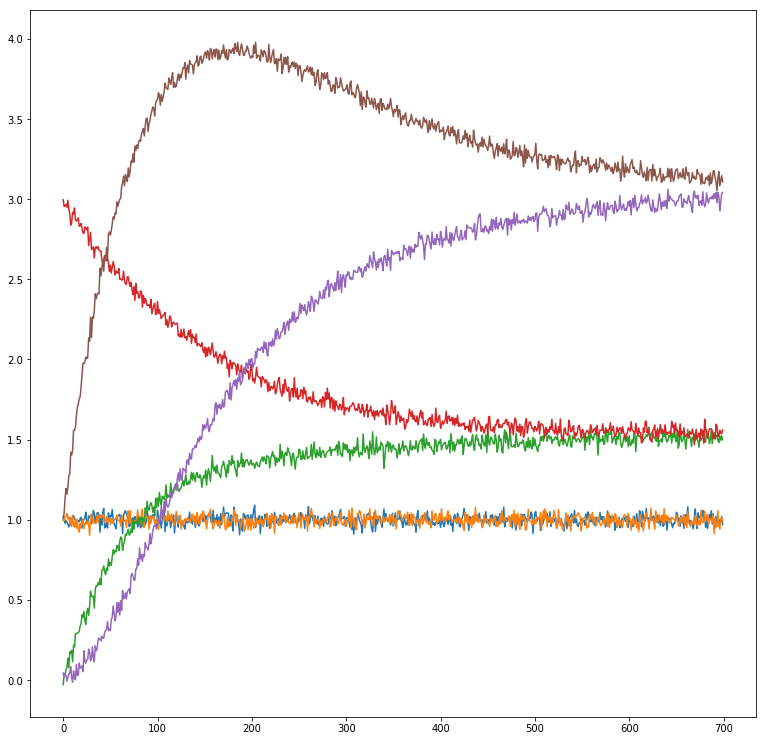

In [27]:
t = analysis.generate_or_load_traj_lma(3, 7, noise_variance=0.001)
plt.plot(t.counts[:, 0])
plt.plot(t.counts[:, 1])
plt.plot(t.counts[:, 2])
plt.plot(t.counts[:, 3])
plt.plot(t.counts[:, 4])
plt.plot(t.counts[:, 5])
plt.show()
t.persist()

dna species 0 -> alpha in (100, 100000)

other species -> alpha lower than 1.

In [28]:
analysis.obtain_lma_trajectories(
    4, noise_variance=0.001, species=[2, 3, 4, 5],
    # alphas=np.linspace(0.0001, 1., num=8),
    alphas=np.array([1.,1.1]),
    verbose=True, 
    atol=5e-5,
    maxit=500, 
    search_depth=1, 
    selection=[3],
    override=True)

obtaining derivative for species [2 3 4 5]
Dont have derivative (got 0 but need 6)
got 700 counts (and 700 corresp. time steps), dt= 0.01


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

found alpha=1.0 to be best with a difference of 0.0650665479123869 between mse and variance
got ix 0


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

MSE = 0.0660665479401 noise variance = 0.001


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

found alpha=1.0 to be best with a difference of 0.029015229245968575 between mse and variance
got ix 0


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

MSE = 0.0300152292609 noise variance = 0.001


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

found alpha=1.0 to be best with a difference of 0.04978654755429822 between mse and variance
got ix 0


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

MSE = 0.0507865475051 noise variance = 0.001


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

found alpha=1.0 to be best with a difference of 0.175076688419376 between mse and variance
got ix 0


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

MSE = 0.175969818454 noise variance = 0.001


In [29]:
analysis.obtain_lma_trajectories(
    4, noise_variance=0.001, species=[0, 1],
    # alphas=np.linspace(0.0001, 1., num=8),
    alphas=np.array([100.,100.1]),
    verbose=True, 
    atol=5e-5,
    maxit=500, 
    search_depth=1, 
    selection=[3],
    override=True)

obtaining derivative for species [0 1]
Dont have derivative (got 4 but need 6)
got 700 counts (and 700 corresp. time steps), dt= 0.01


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

found alpha=100.0 to be best with a difference of 1.7696114800293608e-07 between mse and variance
got ix 0


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

MSE = 0.000999823038853 noise variance = 0.001


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

found alpha=100.1 to be best with a difference of 2.9347551897377397e-05 between mse and variance
got ix 1


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

MSE = 0.000970652448103 noise variance = 0.001


In [30]:
analysis.plot_derivatives(3, species=[1])

AssertionError: 

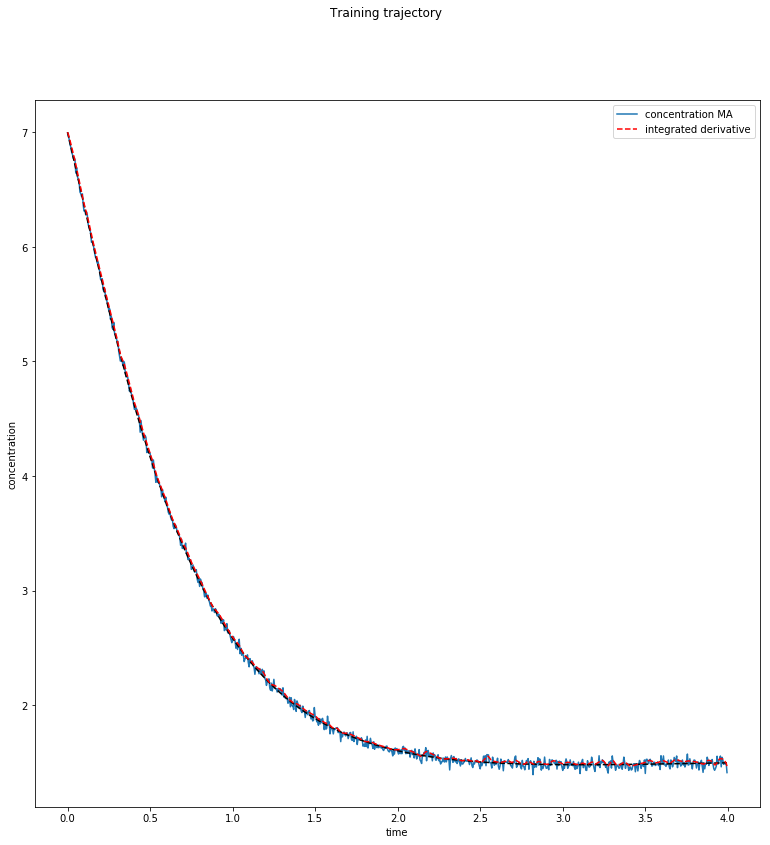

In [11]:
analysis.plot_concentration_curves(4, species=[1])

In [ ]:
analysis.elastic_net(0, alphas=np.linspace(1.,100.,num=8), l1_ratios=)